# Validation for National Intertidal Digital Elevation Model (NIDEM)

**What does this notebook do?** This notebook validates National Intertidal Digital Elevation Model (NIDEM) data against multiple validation datasets (RTK GPS, 5m LIDAR DEM data and multibeam). 

**Date:** April 2018

**Author:** Robbi Bishop-Taylor

## Load modules and define functions

In [1]:
# Import libraries
import sys
import os
import glob
import fiona
import itertools
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
from shapely.geometry import Point
from pyproj import Proj, transform
from osgeo import gdal
from scipy import stats
from matplotlib import pyplot as plt
from IPython.display import display


# Import DEA Notebooks scripts
sys.path.append(os.path.abspath('/g/data/r78/rt1527/dea-notebooks/algorithms'))
import SpatialTools 

# Set working directory
os.chdir('/g/data/r78/rt1527/nidem')


def plot_kde(x_vals, y_vals, nbins=300, y_lims=(-6, 3), x_lims=(-6, 3), power=1.0):

    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    k = stats.kde.gaussian_kde([x_vals, y_vals])
    xi, yi = np.mgrid[y_lims[0]:y_lims[1]:nbins*1j, x_lims[0]:x_lims[1]:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    zi = np.power(zi, power)    

    # Plot output x-y scatter plot
    fig, ax = plt.subplots(figsize = (12, 12))
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap = "magma")
    ax.set_ylim(y_lims[0], y_lims[1])
    ax.set_xlim(x_lims[0], x_lims[1])

    
def reproject_to_template(input_raster, template_raster, output_raster, resolution=None,
                         resampling=gdal.GRA_Average, nodata_val=0):
    
    """
    Reprojects a raster to the extent, cell size, projection and dimensions of a template 
    raster using GDAL. Optionally, can set custom resolution for output reprojected raster
    using 'resolution'; this will affect raster dimensions/width/columns.
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor    
    
    :attr input_raster: path to input geotiff raster to be reprojected (.tif)
    :attr template_raster: path to template geotiff raster (.tif) used to copy extent, projection etc
    :attr output_raster: output reprojected raster path with geotiff extension (.tif)
    :attr resolution: optionally set custom cell size for output reprojected raster; defaults to 
                      'None', or the cell size of template raster 
    :attr resampling: GDAL resampling method to use for reprojection; defaults to gdal.GRA_Average 
    :attr nodata_val: values in the output reprojected raster to set to nodata; defaults to 0
    
    :returns: GDAL dataset for further analysis
    """
    
    # Import raster to reproject
    print("Importing raster datasets")
    input_ds = gdal.Open(input_raster)
    input_proj = input_ds.GetProjection()
    input_geotrans = input_ds.GetGeoTransform()
    data_type = input_ds.GetRasterBand(1).DataType
    n_bands = input_ds.RasterCount  
    
    # Import raster to use as template
    template_ds = gdal.Open(template_raster)   
    template_proj = template_ds.GetProjection()
    template_geotrans = template_ds.GetGeoTransform()
    template_w = template_ds.RasterXSize
    template_h = template_ds.RasterYSize
    
    # Use custom resolution if supplied
    if resolution:
        
        template_geotrans[1] = float(resolution)
        template_geotrans[-1] = -float(resolution)

    # Create new output dataset to reproject into
    output_ds = gdal.GetDriverByName('Gtiff').Create(output_raster, template_w, 
                                                     template_h, n_bands, data_type)  
    output_ds.SetGeoTransform(template_geotrans)
    output_ds.SetProjection(template_proj)
    output_ds.GetRasterBand(1).SetNoDataValue(nodata_val)

    # Reproject raster into output dataset
    print("Reprojecting raster")
    gdal.ReprojectImage(input_ds, output_ds, input_proj, template_proj, resampling)
    
    # Close datasets
    input_ds = None
    template_ds = None    
    
    print("Reprojected raster exported to {}".format(output_raster))
    return output_ds


## RTK GPS validation
Test the resulting DEM by comparing against RTK GPS field-recorded data. Because validation data only exists for polygon 33 (Darwin), this imports DEM data for polygon 33 if another polygon is being analysed.

,gps_elev,nidem_elev
gps_elev,1.00000,0.83304
nidem_elev,0.83304,1.00000


,gps_elev,nidem_elev
gps_elev,1.000000,0.856721
nidem_elev,0.856721,1.000000


RMSE: 0.6204757067849388


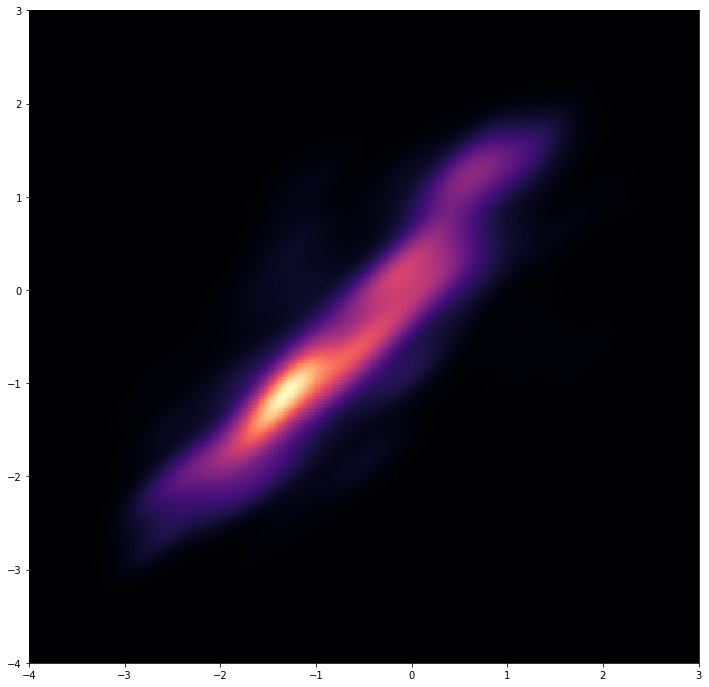

In [45]:
# Import NIDEM polygon 33 from file
nidem_raster = "output_data/dem/NIDEM_dem_33.tif"
nidem_ds = gdal.Open(nidem_raster)
nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray() 

# Open validation point shapefile and use to extract data from underlying array
with fiona.open('raw_data/validation/EastPointonlyRTK_albers.shp') as points:

    point_output = list()

    for n, point in enumerate(points):

        # Extract data from shapefile points; fix units by multiplying by 1000
        x_coord, y_coord = point["geometry"]["coordinates"]
        gps_elev = point["properties"]["field_4"] 

        # Append to list
        point_output.append([x_coord, y_coord, gps_elev])

# Unzip point lists into lists of coords and elevation values
x_coords, y_coords, gps_elev = zip(*point_output) 

# Convert geographic coordinates into index coordinates
x_inds, y_inds =  SpatialTools.coords_to_indices(x_coords=x_coords, y_coords=y_coords,
                                                 input_raster=nidem_raster) 

# Extract NIDEM elevation data and combine into dataframe
nidem_elev = nidem_array[y_inds, x_inds] / 1000.0
gps_val_df = pd.DataFrame({"gps_elev": gps_elev, 
                           "nidem_elev": nidem_elev}).dropna()

# Calculate correlations
display(gps_val_df.corr(method='pearson'))
display(gps_val_df.corr(method='spearman'))

# RMSE
print("RMSE: {}".format(((gps_val_df.nidem_elev - gps_val_df.gps_elev) ** 2).mean() ** 0.5))

# Plot KDE heatmap
plot_kde(x_vals=gps_val_df.gps_elev, 
         y_vals=gps_val_df.nidem_elev, 
         x_lims=(-4, 3), y_lims=(-4, 3), power=1)   


## Lidar validation - correlations

,lidar_elev,nidem_elev
lidar_elev,1.00000,0.93328
nidem_elev,0.93328,1.00000


,lidar_elev,nidem_elev
lidar_elev,1.000000,0.934458
nidem_elev,0.934458,1.000000


RMSE: 0.4326794753861665


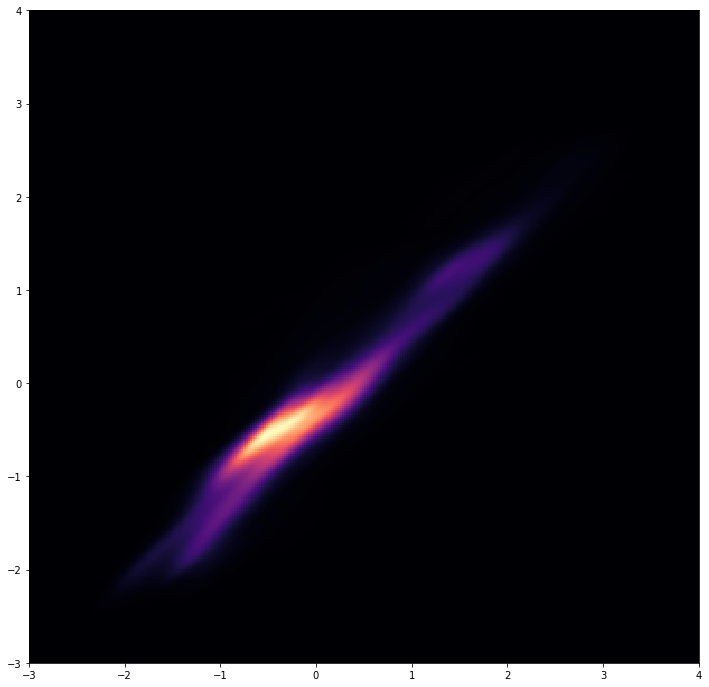

In [47]:
# Dict of study areas and to process; contains matching ITEM polygon and MGA zone for each LIDAR dataset
study_areas_df = pd.read_csv('study_areas.csv', index_col=0)
study_areas = study_areas_df.to_dict('index')

out_list = list()

for key in study_areas:  #['Rockhampton']: # 
    
    print(key)
    
    # Use ITEM polygon and MGA zone from file
    polygon = study_areas[key]['item_polygon']
    mga_zone = study_areas[key]['mga_zone']
    lidar_raster = study_areas[key]['lidar_raster']
  
    # Import Intertidal DEM data
    nidem_ds = gdal.Open("output_data/dem/NIDEM_dem_{}.tif".format(polygon))
    nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray() 
    nidem_prj = nidem_ds.GetProjection()
    nidem_geotrans = nidem_ds.GetGeoTransform()
    
    # Import data
    points_df = pd.read_csv('output_data/validation/output_points_{}.csv'.format(key))  
    
    ulx, lrx = np.percentile(points_df.point_lon, [0, 100])  
    lry, uly = np.percentile(points_df.point_lat, [0, 100]) 
    
    # Clip LIDAR raster to extent of points
    gdal.Translate(destName='scratch/lidar_clipped.tif', 
                   srcDS=lidar_raster, 
                   projWin=[ulx-0.01, uly+0.01, lrx+0.01, lry-0.01],
                   projWinSRS="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    
    # Reproject LIDAR raster to extent/cell size/projection of NIDEM layer
    lidar_reproj = reproject_to_template(input_raster='scratch/lidar_clipped.tif',
                                         template_raster='output_data/dem/NIDEM_dem_{}.tif'.format(polygon), 
                                         output_raster='scratch/lidar_resampled.tif', 
                                         resampling=gdal.GRA_Bilinear, nodata_val=0)   
    
    # Convert lat-lon points to X and Y Australian Albers coords
    x, y = transform(p1=Proj(init='EPSG:4326'), p2=Proj(init="EPSG:3577"),
                     x=points_df['point_lon'].values, y=points_df['point_lat'].values)

    # Convert Australian Albers points to NIDEM raster indices
    x_ind, y_ind = SpatialTools.coords_to_indices(x_coords=x, y_coords=y,
                                     input_raster="output_data/dem/NIDEM_dem_{}.tif".format(polygon))  
    
    # Create mask of areas with exposed non-water LIDAR points
    mask_unfiltered = np.full(nidem_array.shape, False) 
    mask_unfiltered[y_ind, x_ind] = True
    mask_unfiltered = ndimage.binary_fill_holes(mask_unfiltered)
    mask_unfiltered = ndimage.binary_erosion(mask_unfiltered)
    mask = ndimage.binary_dilation(mask_unfiltered)
    
    # Extract LIDAR and NIDEM elevation data
    lidar_elev = lidar_reproj.GetRasterBand(1).ReadAsArray()[mask]   
    nidem_elev = nidem_array[mask] / 1000.0
    
    # Combine into dataframe
    test_df = pd.DataFrame({"lidar_elev": lidar_elev, "nidem_elev": nidem_elev}).dropna()
    out_list.append(test_df)
    print('    Comparing {} raster pixels'.format(len(test_df)))
    
    # Export mask to file
    SpatialTools.array_to_geotiff(fname = "scratch/lidar_mask_{}.tif".format(key), 
                                  data = mask, 
                                  geo_transform = nidem_geotrans, 
                                  projection = nidem_prj, 
                                  nodata_val = 0)
    
    # Close datasets
    lidar_reproj = None
    nidem_ds = None
    
# Combine into single dataframe
lidar_val_df = pd.concat(out_list) 

# Calculate correlations
display(lidar_val_df.corr(method='pearson'))
display(lidar_val_df.corr(method='spearman'))

# RMSE
print("RMSE: {}".format(((lidar_val_df.nidem_elev - lidar_val_df.lidar_elev) ** 2).mean() ** 0.5))

# Take random sample
lidar_val_df = lidar_val_df.sample(20000)

# Plot KDE heatmap
plot_kde(x_vals=lidar_val_df.lidar_elev, 
         y_vals=lidar_val_df.nidem_elev, 
         x_lims=(-3, 4), y_lims=(-3, 4), power=1.0)   


## Multibeam validation - correlations

,multibeam_elev,nidem_elev
multibeam_elev,1.000000,0.320035
nidem_elev,0.320035,1.000000


,multibeam_elev,nidem_elev
multibeam_elev,1.000000,0.734835
nidem_elev,0.734835,1.000000


RMSE: 4.3762865627126715


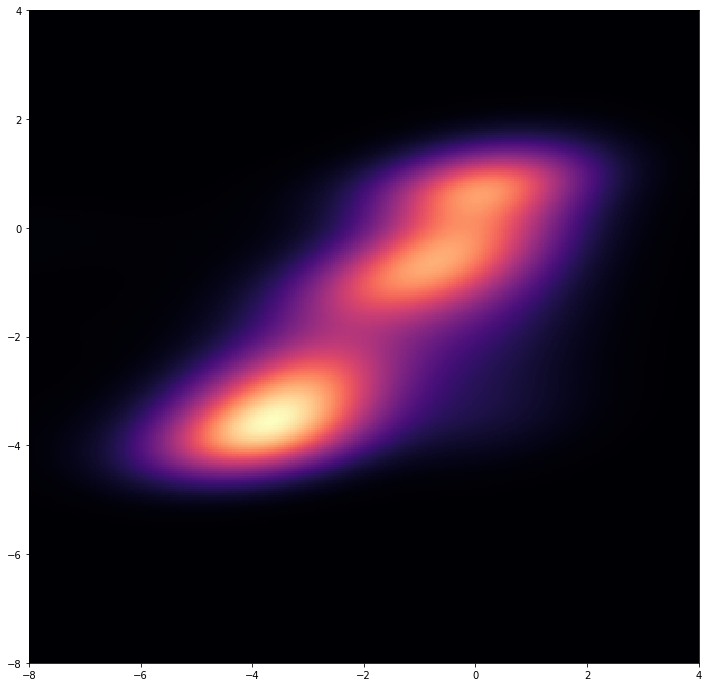

In [46]:
# Paths to multibeam datasets
multibeam_paths = glob.glob("raw_data/validation/WAMSI_KimberlyReefs/*.tif")

# Merge NIDEM polygons with gdal_merge
os.system('gdal_merge.py -n 0 -a_nodata 0 -o ' \
          'scratch/nidem_merged.tif ' \
          'output_data/dem/NIDEM_dem_78.tif ' \
          'output_data/dem/NIDEM_dem_139.tif ' \
          'output_data/dem/NIDEM_dem_152.tif')

# Merge multibeam datasets with gdal_merge
os.system('gdal_merge.py -n -9999 -a_nodata -9999 -o ' \
          'scratch/multibeam_merged.tif {}'.format(' '.join(multibeam_paths)))

# Reproject merged multibeam raster into dims/extent/proj of merged NIDEM raster 
reproject_to_template(input_raster='scratch/multibeam_merged.tif',
                      template_raster='scratch/nidem_merged.tif',                           
                      output_raster='scratch/multibeam_reproj.tif',
                      resampling=gdal.GRA_Bilinear)

# Import merged multibeam array
multibeam_ds = gdal.Open('scratch/multibeam_reproj.tif')
multibeam_array = multibeam_ds.GetRasterBand(1).ReadAsArray()

# Import merged NIDEM array
nidem_ds = gdal.Open('scratch/nidem_merged.tif')
nidem_array = nidem_ds.GetRasterBand(1).ReadAsArray()

# Extract elevation data
mask = (multibeam_array != 0.) & (nidem_array != 0.)
multibeam_elev = multibeam_array[mask] 
nidem_elev = nidem_array[mask] / 1000.0

# Combine into dataframe
multibeam_val_df = pd.DataFrame({'multibeam_elev': multibeam_elev, 
                                 'nidem_elev': nidem_elev}).dropna()

# Correlations
display(multibeam_val_df.corr(method='pearson'))
display(multibeam_val_df.corr(method='spearman'))

# RMSE
print("RMSE: {}".format(((multibeam_val_df.nidem_elev - multibeam_val_df.multibeam_elev) ** 2).mean() ** 0.5))

# Plot KDE heatmap
plot_kde(x_vals=multibeam_val_df["multibeam_elev"], 
         y_vals=multibeam_val_df["nidem_elev"], 
         x_lims=(-8, 4), y_lims=(-8, 4), power=1.0)


## Export NIDEM elevations and ranges per polygon

In [25]:
out_list = list()

# For each NIDEM DEM, export .csv of min, max elevations and range
for dem in glob.glob("output_data/dem/*.tif"):
    
    # open raster and choose band to find min, max
    gtif = gdal.Open(dem)
    srcband = gtif.GetRasterBand(1)

    # Get raster statistics
    stats = srcband.GetStatistics(True, True)
    
    # Get attributes
    polygon = dem.split("_")[-1][:-4]
    elev_min = stats[0]
    elev_max = stats[1]
    elev_range = elev_max - elev_min
    
    # Append to list
    out_list.append([polygon, elev_min, elev_max, elev_range])    
    
    gtif = None

# Combine values into pandas dataframe and export to .csv
polygon_elev_df = pd.DataFrame(out_list, columns=['ID', 'elev_min', 'elev_max', 'elev_range'])
polygon_elev_df.to_csv("nidem_polygons.csv", index=False)
    
    